In [2]:
import time
import random
import numpy as np
import pandas as pd
import torch
import os

from custom_trading_env import TradingEnv
import DQNTradingAgent.dqn_agent as dqn_agent
from arguments import argparser

In [3]:
df = pd.read_hdf('./dataset/binance_data_test.h5', 'STW')
df.fillna(method='ffill', inplace=True)

sample_len   = len(df)
obs_data_len = 192
step_len     = 1
n_action_intervals = 5
init_budget = 1
fee = 0.0001

env = TradingEnv(custom_args=object(), env_id='custom_trading_env', obs_data_len=obs_data_len, step_len=step_len, sample_len=sample_len,
                 df=df, fee=fee, initial_budget=1, n_action_intervals=n_action_intervals, deal_col_name='c', sell_at_end=True,
                 feature_names=['o', 'h','l','c','v',
                                'num_trades', 'taker_base_vol'])

[2019-07-24 14:16:09,419] Making new env: custom_trading_env


In [4]:
total_volume = []
total_fee = []
for i in range(1,27+1):
    print("Agent", i)
    t0 = time.time()
    save_location = 'saves/transfer1/0.0001/{}'.format(i)

    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    dqn_agent.set_device(device)
    load_weight_n = 500

    state = env.reset()
    # env.render()

    hyperparams = torch.load(os.path.join(save_location, "hyperparams.pth"))

    agent = dqn_agent.Agent(action_size=2 * n_action_intervals + 1, obs_len=obs_data_len, num_features=state.shape[-1], **hyperparams)
    agent.qnetwork_local.load_state_dict(torch.load(os.path.join(save_location, 'TradingGym_Rainbow_{:d}.pth'.format(load_weight_n)), map_location=device))
    agent.qnetwork_local.to(device)
    agent.qnetwork_local.eval()

    done = False
    
    t1 = time.time()
    print("    Preparation time: {:f}s".format(t1 - t0))

    while not done:

        action = int(agent.act(state))
        state, reward, done, info = env.step(action)
    #     print()
    #     print("Action:", action)
    #     print("Budget:", env.budget)
    #     print("Reward:", reward)
        if done:
            break
    
    t2 = time.time()
    print("    Episode time: {:f}s".format(t2 - t1))

    total_volume.append(info['position_variation'].abs().sum())
    
    if not os.path.exists(f"Results/{str(fee)}/"):
        os.makedirs(f"Results/{str(fee)}")
    info.to_csv(f"Results/{str(fee)}/info_{i}.csv")
    total_fee.append(env.total_fee)
    print("    Post-processing time: {:f}s".format(time.time() - t2))

/home/jeffrey/Binanace_trading_simulation/TradingGym/custom_trading_env.py:99: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.price = self.df_sample[self.price_name].as_matrix()
/home/jeffrey/Binanace_trading_simulation/TradingGym/custom_trading_env.py:101: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.obs_features = self.df_sample[self.using_feature].as_matrix()


Agent 1
    Preparation time: 3.558310s
    Episode time: 12.332304s
    Post-processing time: 0.070294s
Agent 2
    Preparation time: 0.072453s
    Episode time: 11.946267s
    Post-processing time: 0.072251s
Agent 3
    Preparation time: 0.163347s
    Episode time: 11.953997s
    Post-processing time: 0.072080s
Agent 4
    Preparation time: 0.057175s
    Episode time: 11.916726s
    Post-processing time: 0.068141s
Agent 5
    Preparation time: 0.115867s
    Episode time: 12.014687s
    Post-processing time: 0.068544s
Agent 6
    Preparation time: 0.081664s
    Episode time: 12.092768s
    Post-processing time: 0.067834s
Agent 7
    Preparation time: 0.159277s
    Episode time: 11.967421s
    Post-processing time: 0.067891s
Agent 8
    Preparation time: 0.125754s
    Episode time: 12.100076s
    Post-processing time: 0.066886s
Agent 9
    Preparation time: 0.166195s
    Episode time: 11.999529s
    Post-processing time: 0.066381s
Agent 10
    Preparation time: 0.150077s
    Episode ti

In [5]:
len(total_fee)

27

In [6]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'N_agent')

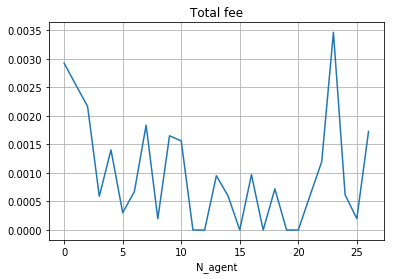

In [7]:
plt.plot(total_fee)
plt.grid()
plt.title("Total fee")
plt.xlabel("N_agent")

Text(0.5, 0, 'N_agent')

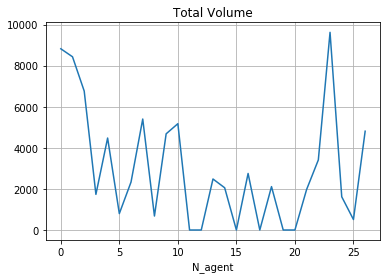

In [8]:
plt.plot(total_volume)
plt.grid()
plt.title("Total Volume")
plt.xlabel("N_agent")

In [9]:
import pickle as pkl

In [10]:
with open(f"Results/{fee}_total_fee", 'wb') as pickle_file:
    pkl.dump(total_fee, pickle_file)
with open(f"Results/{fee}_total_volume", 'wb') as pickle_file:
    pkl.dump(total_volume, pickle_file)